In [84]:
from rtree.index import Index as RTreeIndex
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [15]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'
LOG_DIR = '../../../log'

In [60]:
UNSUPPORTED_ROUTES = [
    'M35',
    'M60+',
]

In [137]:
road_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/road.graphml')

In [72]:
p = Polygon([
            [
              -122.27465629577637,
              37.7983230783235
            ],
            [
              -122.26096630096434,
              37.7983230783235
            ],
            [
              -122.26096630096434,
              37.80761398306056
            ],
            [
              -122.27465629577637,
              37.80761398306056
            ],
            [
              -122.27465629577637,
              37.7983230783235
            ]
          ])

west, south, east, north = p.bounds
road_mg = ox.graph_from_bbox(north, south, east, west)

In [138]:
rows = []
for start_node_id, end_node_id, edge in road_mg.edges(data=True):
    geometry = None
    if 'geometry' in edge.keys():
        geometry = edge['geometry']
    else:
        start_node = road_mg.nodes[start_node_id]
        end_node = road_mg.nodes[end_node_id]
        geometry = LineString([[start_node['x'], start_node['y']],
                               [end_node['x'], end_node['y']]])
    row = {
        'start_node_id': start_node_id,
        'end_node_id': end_node_id,
        'osmid': edge['osmid'],
        'length': edge['length'],
        'geometry': geometry,
    }
    rows.append(row)
road_gdf = gpd.GeoDataFrame(rows)

In [139]:
routes_gdf = gpd.read_file(
    f'{EXPORTS_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp', crs=CRS_LATLON)
routes_gdf = routes_gdf.to_crs(CRS_LATLON)

# Remove unsupported routes.
routes_gdf = routes_gdf[~routes_gdf['route_id'].isin(UNSUPPORTED_ROUTES)]

In [140]:
trace = routes_gdf.loc[0, 'geometry']

In [75]:
trace = LineString([[-122.26694762706754, 37.79925985116652],
                    [-122.26666867732999, 37.79970068133491],
                    [-122.2660920023918, 37.800605646561564],
                    [-122.26770132780074, 37.80126899810456],
                    [-122.26859986782071, 37.80141311202907],
                    [-122.26758331060408, 37.80292417198254],
                    [-122.26653456687926, 37.804909907830265],
                    [-122.26547777652739, 37.806312818153785],
                    [-122.26666331291199, 37.80684261119228],
                    [-122.26750552654266, 37.80545242616099],
                    [-122.26820826530457, 37.80428685451822],
                    [-122.27041840553284, 37.80534222744762],
                    [-122.27078318595886, 37.80484209275872],
                    [-122.27197408676149, 37.8028076116559],
                    [-122.27447390556335, 37.80395201417224]])

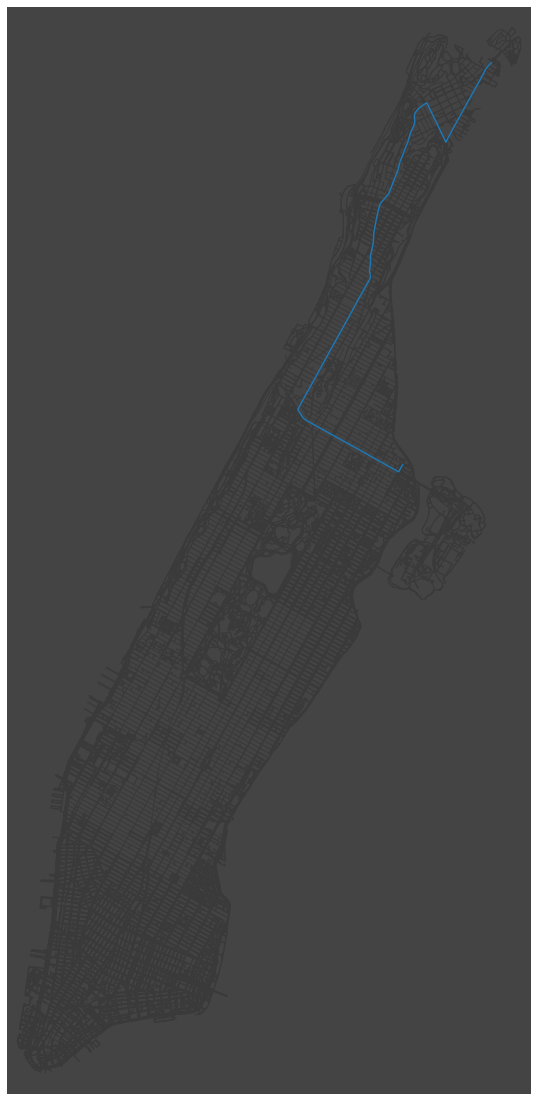

In [141]:
fig, ax = plt.subplots(figsize=(20, 20))

ox.plot_graph(road_mg,
              ax=ax,
              bgcolor='#444',
              node_size=0,
              show=False,
              close=False,
              edge_color='#3a3a3a')

gpd.GeoSeries(trace, crs=CRS_LATLON).plot(ax=ax)

ax.set_facecolor('#444')
plt.show()

In [142]:
def haversine(lat1, lon1, lat2, lon2):
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    dist_lon = lon2 - lon1
    dist_lat = lat2 - lat1

    a = (math.sin(dist_lat / 2)**2 +
         math.cos(lat1) * math.cos(lat2) * math.sin(dist_lon / 2)**2)
    c = 2 * math.asin(math.sqrt(a))
    km = 6371 * c
    return 1000 * km

In [143]:
def get_geoms(G):
    return ox.utils_graph.graph_to_gdfs(G, nodes=False)['geometry']

def get_rtree(G, geoms):
    # build the r-tree spatial index by position for subsequent iloc
    rtree = RTreeIndex()
    for pos, bounds in enumerate(geoms.bounds.values):
        rtree.insert(pos, bounds)
    return rtree

road_geoms = get_geoms(road_mg)
road_rtree = get_rtree(road_mg, road_geoms)

In [144]:
# This needs to be converted to use OSMNX rtree and k-nearest edges.
def get_near_edges(gdf, x, y, threshold=100):
    p = Point(x, y)
    near_edges = []
    
    for i, row in gdf.iterrows():
        geometry = row['geometry']
        snap_point = geometry.interpolate(geometry.project(p))
        snap_dist = haversine(y, x, snap_point.y, snap_point.x)
        if snap_dist < threshold:
            near_edges.append({
                'id': i,
                'distance': snap_dist,
                'start_node_id': row['start_node_id'],
                'end_node_id': row['end_node_id'],
            })
    return near_edges

In [145]:
class StateNode:

    def __init__(self,
                 trace_id,
                 edge_id,
                 distance,
                 start_node_id,
                 end_node_id,
                 terminal=None):
        self.trace_id = trace_id
        self.edge_id = edge_id
        self.distance = distance
        self.start_node_id = start_node_id
        self.end_node_id = end_node_id
        self.terminal = terminal

In [146]:
def get_k_nearest_edges(rtree, geoms, x, y, k=10):
    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    xy = (x, y)
    dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
    dists_df = pd.DataFrame([a[0][0:2] + (a[1],) for a in zip(dists.index, dists)], columns=['u', 'v', 'dist'])
    result_df = dists_df.nsmallest(k, 'dist', keep='first').reset_index(drop=True)
    edges = []
    for i, row in result_df.iterrows():
        edge = {
            'start_node_id': int(row['u']),
            'end_node_id': int(row['v']),
            'distance': row['dist'],
        }
        edge['id'] = road_gdf[(road_gdf['start_node_id'] == edge['start_node_id']) & (road_gdf['end_node_id'] == edge['end_node_id'])].iloc[0].name
        edges.append(edge)
    return edges

In [147]:
markov_chain = nx.DiGraph()

start_state_node = StateNode(None, None, None, None, None, 'start')
markov_chain.add_node(start_state_node)

last_state = [start_state_node]

for trace_id, xy in tqdm(list(enumerate(trace.coords))):
    current_state = []
    x, y = xy

    #edges = get_near_edges(road_gdf, x, y)
    edges = get_k_nearest_edges(road_rtree, road_geoms, x, y)

    for edge in edges:
        next_state_node = StateNode(trace_id, edge['id'], edge['distance'],
                                    edge['start_node_id'], edge['end_node_id'])
        markov_chain.add_node(next_state_node)
        current_state.append(next_state_node)

        for last_node in last_state:
            markov_chain.add_edge(last_node, next_state_node)

    last_state = current_state

end_state_node = StateNode(None, None, None, None, None, 'end')
markov_chain.add_node(end_state_node)
for last_node in last_state:
    markov_chain.add_edge(last_node, end_state_node)

100%|██████████| 268/268 [00:03<00:00, 72.14it/s]


In [150]:
def get_edge_likelihood(start_state_node, end_state_node, attributes):
    if start_state_node.terminal == 'start' or end_state_node.terminal == 'end':
        return 1
    
    emission_weight = start_state_node.distance ** 2
    
    try:
        path = nx.dijkstra_path(road_mg, start_state_node.end_node_id, end_state_node.start_node_id, weight='length')
        lengths = []
        for start_node_id, end_node_id in zip(path[:-1], path[1:]):
            lengths.append(road_mg[start_node_id][end_node_id][0]['length'])
        distance = sum(lengths)
    except nx.NetworkXNoPath:
        distance = 1000000
        
    transition_weight = distance ** 2
    
    return emission_weight + transition_weight

In [151]:
path = nx.dijkstra_path(markov_chain, start_state_node, end_state_node, weight=get_edge_likelihood)

In [153]:
path_trimmed = [state_node for state_node in path if state_node.edge_id is not None]
path_edges = []
for state_node in path_trimmed:
    row = road_gdf.loc[state_node.edge_id]
    
    if len(path_edges) == 0:
        path_edges.append(row)
        continue
        
    last_edge = path_edges[-1]
    if last_edge['end_node_id'] == row['start_node_id']:
        path_edges.append(row)
        continue
        
    subpath = nx.dijkstra_path(road_mg, last_edge['end_node_id'], row['start_node_id'], weight='length')
    for start_node_id, end_node_id in zip(subpath[:-1], subpath[1:]):
        mask_1 = road_gdf['start_node_id'] == start_node_id
        mask_2 = road_gdf['end_node_id'] == end_node_id
        subpath_row = road_gdf[mask_1 & mask_2].head(1).squeeze()
        path_edges.append(subpath_row)
        
path_gdf = gpd.GeoSeries([row['geometry'] for row in path_edges], crs=CRS_LATLON)

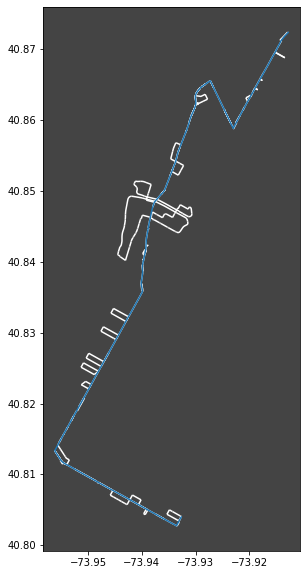

In [157]:
fig, ax = plt.subplots(figsize=(10, 10))

#ox.plot_graph(road_mg,
#              ax=ax,
#              bgcolor='#444',
#              node_size=0,
#              show=False,
#              close=False,
#              edge_color='#3a3a3a')

path_gdf.plot(ax=ax, color='#fff')
gpd.GeoSeries(trace, crs=CRS_LATLON).plot(ax=ax)

ax.set_facecolor('#444')
plt.show()